In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
import argparse

from utils import *

np.random.seed(42)

/home/wanhr/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_1.csv"
local_ip = "10.215.173.1"

In [ ]:
df = load_csv(filename)
# stats_src_ip(df)
# stats_dst_ip(df)
dl_pkt_interval = extract_dl_pkt_interval_time(df, local_ip)
ul_pkt_interval = extract_ul_pkt_interval_time(df, local_ip)

dl_pkt_interval = dl_pkt_interval[dl_pkt_interval < 0.2] * 1000 # in ms
ul_pkt_interval = ul_pkt_interval[ul_pkt_interval < 0.2] * 1000 # in ms

In [4]:
with pm.Model() as gamma_model:
  alpha = pm.Exponential("alpha", 0.1)
  beta = pm.Exponential("beta", 0.1)

  y = pm.Gamma("y", alpha, beta, observed=dl_pkt_interval)
  mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))

/home/wanhr/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 8.66e+05


In [5]:
with gamma_model:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/home/wanhr/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


In [6]:
mean_field

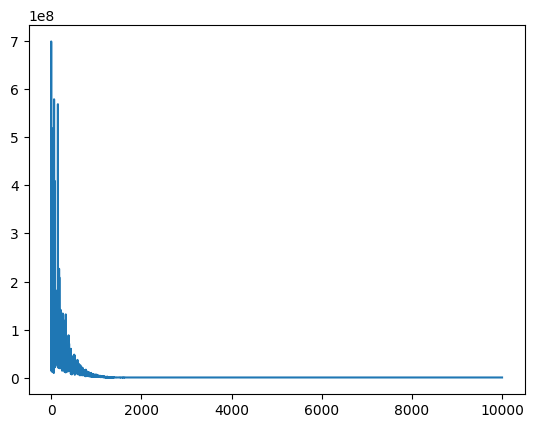

In [7]:
plt.plot(mean_field.hist)

In [9]:
approx_sample = mean_field.sample(1000)

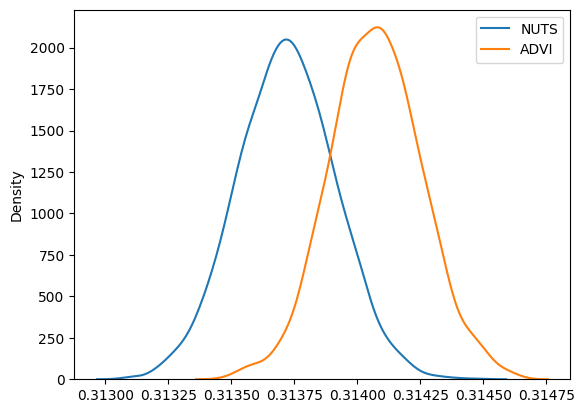

In [10]:
sns.kdeplot(trace.posterior["alpha"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["alpha"].values.flatten(), label="ADVI")
plt.legend();

In [21]:
w = np.array([0.2, 0.8])
mu = np.array([-0.3, 0.5])
sd = np.array([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    x2 = x**2
    sin_x = pm.math.sin(x)

In [22]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

In [23]:
with model:
    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


/home/wanhr/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


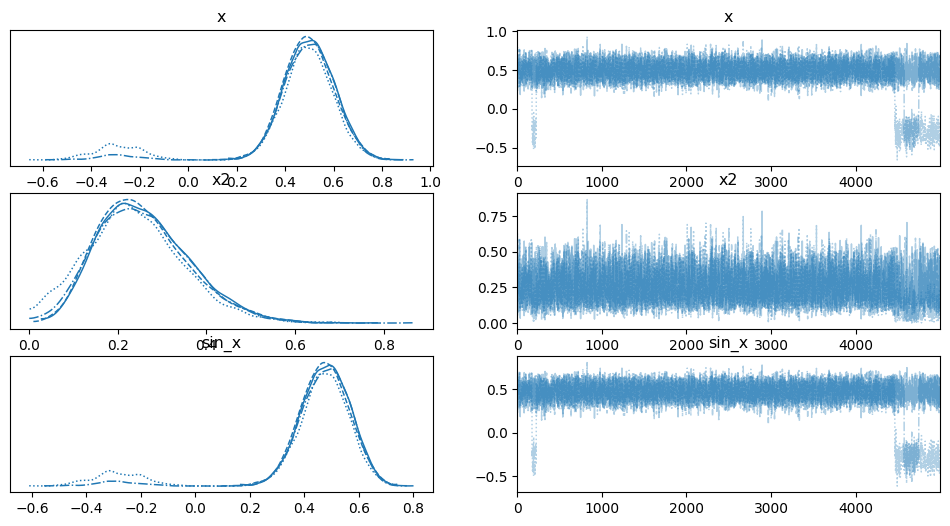

In [24]:
az.plot_trace(trace);

In [29]:
with model:
    mean_field = pm.fit(method="advi")

/home/wanhr/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 2.0761


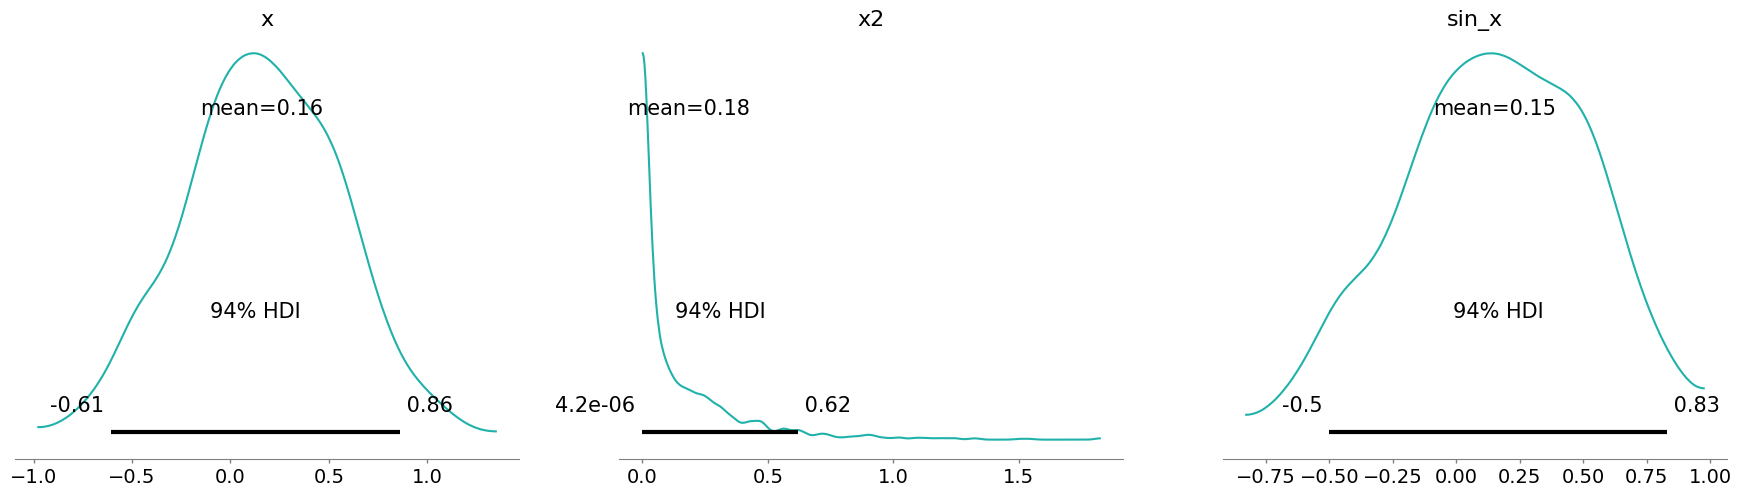

In [30]:
az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");